In [20]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
from sklearn.metrics import roc_auc_score

import itertools

from pandas.api.types import CategoricalDtype
import os


In [21]:
overwrite_existing_results = True
results_directory = "Results/population/LOO/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

groups = ["uniform", "diverse"]
groups.sort()
print("groups = " + str(groups))

context_depth = 2;
nback_depth   = 1;
session_numbers = None#[1]; # index by 1
number_of_trials    = 50;

action_labels = [0,1,2]

groups = ['diverse', 'uniform']


In [22]:
def run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label):
    model = cdCRP(sequences_c,
                    session_labels=session_types_c,
                    subject_labels=subject_labels_c,
                    population_labels=population_labels_c,
                    possible_observations=action_labels);
    model.same_nback_depth = nback_depth
    model.context_depth = context_depth

    model.build(random_seed=stan_seed);
    model.fit_model()

    fit_df  = model.fit.to_frame()
    summary_df = model.fit_summary()

    fit_df["loo_subject"]   = subject_label
    summary_df["loo_subject"] = subject_label

    if(session_numbers is None):
        summary_df["number_of_trials"] = number_of_trials
        summary_df["start_session_C"]  = pd.NA
        summary_df["end_session_C"]    = pd.NA
        fit_df["number_of_trials"] = number_of_trials
        fit_df["start_session_C"]  = pd.NA
        fit_df["end_session_C"]    = pd.NA
    else:
        start_session = np.min(session_numbers)
        end_session = np.max(session_numbers)
        summary_df["number_of_trials"] = pd.NA
        summary_df["start_session_C"]  = start_session
        summary_df["end_session_C"]    = end_session
        fit_df["number_of_trials"] = pd.NA
        fit_df["start_session_C"]  = start_session
        fit_df["end_session_C"]    = end_session
    return fit_df, summary_df

In [23]:
def xval_sequence(seq, fit_df):
    Y = np.array(seq,dtype=float);
    N = Y.size



    deltas = np.arange(0,N)[:,np.newaxis] - np.arange(0,N)[np.newaxis,:]

    is_prev = deltas > 0;
    is_same = (Y[:,np.newaxis] == Y[np.newaxis,:])
    

    ctx = Y.copy()
    A = (ctx[:,np.newaxis] != ctx[np.newaxis,:])
    cd = np.zeros((N,N,context_depth))
    for depth in range(context_depth):
        ctx = np.roll(ctx,1)
        ctx[0] = np.nan
        A = (ctx[:,np.newaxis] != ctx[np.newaxis,:]) | A
        cd[:,:,depth] = A;


    if(context_depth > 0):
        ctx = np.roll(Y.copy(), 1)
        ctx[0] = np.nan
        sb = Y == ctx
    else:
        sb = 0;
    

    M = len(action_labels)

    def compute_log_p(df_row):
        tau = df_row["timeconstant_within_session_C"]
        alpha = df_row["alpha"]
        

        if(nback_depth > 0):
            repeat_bias_1_back_0 = df_row["repeat_bias_1_back"]
            BaseMeasure = (sb * (repeat_bias_1_back_0-1.0) + 1.0) / (repeat_bias_1_back_0 + (M-1.0));
        else:
            BaseMeasure = 1.0/M;
        if(context_depth > 0):
            C = np.array([df_row[f"context_similarity_depth_{xx}"] for xx in range(1,context_depth+1)])
            cm = np.sum(np.log(1-C[np.newaxis,np.newaxis,:]) * cd, axis=2)
        else:
            cm = 0;
        X = np.exp(- deltas/tau + cm) * is_prev
        Y = X * is_same

        log_P = np.log(Y.sum(axis=1) + alpha*BaseMeasure) - np.log(X.sum(axis=1) + alpha)
        return log_P.sum()

    return fit_df.apply(compute_log_p, axis=1)


In [24]:
if(session_numbers is None):
    fit_file = f"{results_directory}/fits_trials_{number_of_trials}"
    fit_summary_file = f"{results_directory}/fit_summary_trials_{number_of_trials}"
    seed_offset = number_of_trials
    xval_file = f"{results_directory}/xval_trials_{number_of_trials}"
else:
    start_session = np.min(session_numbers)
    end_session = np.max(session_numbers)
    fit_file = f"{results_directory}/fits_session_{start_session}"
    fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
    if(end_session != start_session):
        fit_file += f"_to_{start_session}"
        fit_summary_file  += f"_to_{start_session}"
    seed_offset = start_session
    xval_file = f"{results_directory}/xval_session_{start_session}"

fit_file += f"_cd{context_depth}_nb{nback_depth}"
fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"
xval_file += f"_cd{context_depth}_nb{nback_depth}"

fit_file += f".pkl"
fit_summary_file += f".pkl"
xval_file += f".pkl"


sequences = []
session_types = []
subject_labels = []
population_labels = []
for group in groups:
    for subject_p in data["group_definition"][group]:
        sequences_0 = data["data"][subject_p]["data"]; # turns in each session
        session_types_0 = data["data"][subject_p]["task"] # which maze

        if(session_numbers is None):
            ii = list(np.where(np.array(session_types_0)=='C')[0])
            seqs_c = [sequences_0[xx] for xx in ii]
            seqs_c = list(itertools.chain.from_iterable(seqs_c))
            sequences += [seqs_c[:number_of_trials]]
            session_types += ['C']
            subject_labels += [subject_p]
            population_labels += [group]
        else:
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
            sequences     += [sequences_0[xx] for xx in ii]
            session_types += [session_types_0[xx] for xx in ii]
            subject_labels += [subject_p] * len(ii)
            population_labels += [group]* len(ii)
            if(len(ii) > 1):
                raise ValueError("only should do one sequence per subject")


if(not os.path.isfile(xval_file) or overwrite_existing_results):
    # data_fits = pd.DataFrame()
    # data_fit_metrics = pd.DataFrame()
    xval_df = pd.DataFrame()
    for subject_index, subject in enumerate(subject_labels):
        population = population_labels[subject_index];
        print(f"subject {subject} in group {population}")

        stan_seed = (subject_index+1) * 1000 + seed_offset
        sequences_c          = [xx for (xx,yy,zz) in zip(sequences, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
        session_types_c      = [xx for (xx,yy,zz) in zip(session_types, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
        subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
        population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
        subject_label = subject
        print(f"fitting with {subject_labels_c}")

        fit_df, summary_df = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label)

        # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

        test_seq = sequences[subject_labels.index(subject)]
        ts = xval_sequence(test_seq, fit_df)
        df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "LOO"})
        xval_df        = pd.concat([xval_df,df_c], copy=False)
    for group_index, group in enumerate(groups):
        print(f"population {population}")

        stan_seed = (group_index+1) * 10000 + seed_offset
        sequences_c          = [xx for (xx,yy,zz) in zip(sequences, subject_labels, population_labels) if  (zz == group) ]
        session_types_c      = [xx for (xx,yy,zz) in zip(session_types, subject_labels, population_labels) if  (zz == group) ]
        subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels, subject_labels, population_labels) if (zz == group) ]
        population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if (zz == group) ]
        subject_label = group
        print(f"fitting with {subject_labels_c}")

        fit_df, summary_df = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label)

        # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

        for test_seq, subject in zip(sequences_c, subject_labels_c):
            ts = xval_sequence(test_seq, fit_df)
            df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "train"})
            xval_df        = pd.concat([xval_df,df_c], copy=False)

        sequences_c          = [xx for (xx,yy,zz) in zip(sequences, subject_labels, population_labels) if  (zz != group) ]
        subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels, subject_labels, population_labels) if (zz != group)]

        for test_seq, subject in zip(sequences_c, subject_labels_c):
            ts = xval_sequence(test_seq, fit_df)
            df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "cross"})
            xval_df        = pd.concat([xval_df,df_c], copy=False)


    # data_fits.to_pickle(fit_file)
    # data_fit_metrics.to_pickle(fit_summary_file)
    xval_df.to_pickle(xval_file)
else:
    print("fit file found")
    xval_df = pd.read_pickle(xval_file)



subject F2 in group diverse
fitting with ['G2', 'I2', 'J2', 'A2', 'B2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.010087 seconds
  1000 transitions using 10 leapfrog steps per transition would take 100.87 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp/httpstan_lyxdtpov/model_bzb5gz3i.stan', line 149, column 4 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp/

subject G2 in group diverse
fitting with ['F2', 'I2', 'J2', 'A2', 'B2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.009343 seconds
  1000 transitions using 10 leapfrog steps per transition would take 93.43 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because o

subject I2 in group diverse
fitting with ['F2', 'G2', 'J2', 'A2', 'B2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  13% (1001/8000)
Sampling:  14% (1100/8000)
Sam

subject J2 in group diverse
fitting with ['F2', 'G2', 'I2', 'A2', 'B2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject A2 in group diverse
fitting with ['F2', 'G2', 'I2', 'J2', 'B2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject B2 in group diverse
fitting with ['F2', 'G2', 'I2', 'J2', 'A2', 'C2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject C2 in group diverse
fitting with ['F2', 'G2', 'I2', 'J2', 'A2', 'B2', 'D2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject D2 in group diverse
fitting with ['F2', 'G2', 'I2', 'J2', 'A2', 'B2', 'C2', 'E2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject E2 in group diverse
fitting with ['F2', 'G2', 'I2', 'J2', 'A2', 'B2', 'C2', 'D2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject F1 in group uniform
fitting with ['G1', 'H1', 'I1', 'J1', 'A1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject G1 in group uniform
fitting with ['F1', 'H1', 'I1', 'J1', 'A1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject H1 in group uniform
fitting with ['F1', 'G1', 'I1', 'J1', 'A1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject I1 in group uniform
fitting with ['F1', 'G1', 'H1', 'J1', 'A1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject J1 in group uniform
fitting with ['F1', 'G1', 'H1', 'I1', 'A1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject A1 in group uniform
fitting with ['F1', 'G1', 'H1', 'I1', 'J1', 'B1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject B1 in group uniform
fitting with ['F1', 'G1', 'H1', 'I1', 'J1', 'A1', 'C1', 'D1', 'E1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)

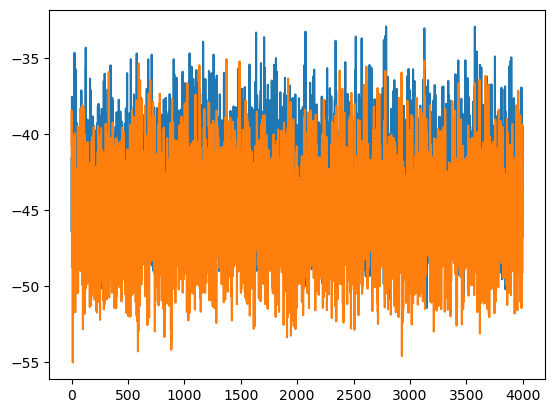

In [ ]:
sns.boxplot(data=xval_df, x="subject", y="log_likelihood", hue="train_condition")